In [3]:
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 300
plt.rcParams['savefig.dpi'] = 300

In [4]:
credit = pd.read_csv('german_credit_data.csv')

In [5]:
credit.head()

,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose,Risk
0,0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,2,49,male,1,own,little,NaN,2096,12,education,good
3,3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,4,53,male,2,free,little,little,4870,24,car,bad


In [6]:
del credit['Unnamed: 0']

In [7]:
credit.describe()

,Age,Job,Credit amount,Duration
count,1000.000000,1000.000000,1000.000000,1000.000000
mean,35.546000,1.904000,3271.258000,20.903000
std,11.375469,0.653614,2822.736876,12.058814
min,19.000000,0.000000,250.000000,4.000000
25%,27.000000,2.000000,1365.500000,12.000000
50%,33.000000,2.000000,2319.500000,18.000000
75%,42.000000,2.000000,3972.250000,24.000000
max,75.000000,3.000000,18424.000000,72.000000


In [8]:
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.rcParams["figure.figsize"] = (10,6)

In [9]:
numerical_credit = credit.select_dtypes(exclude='O')

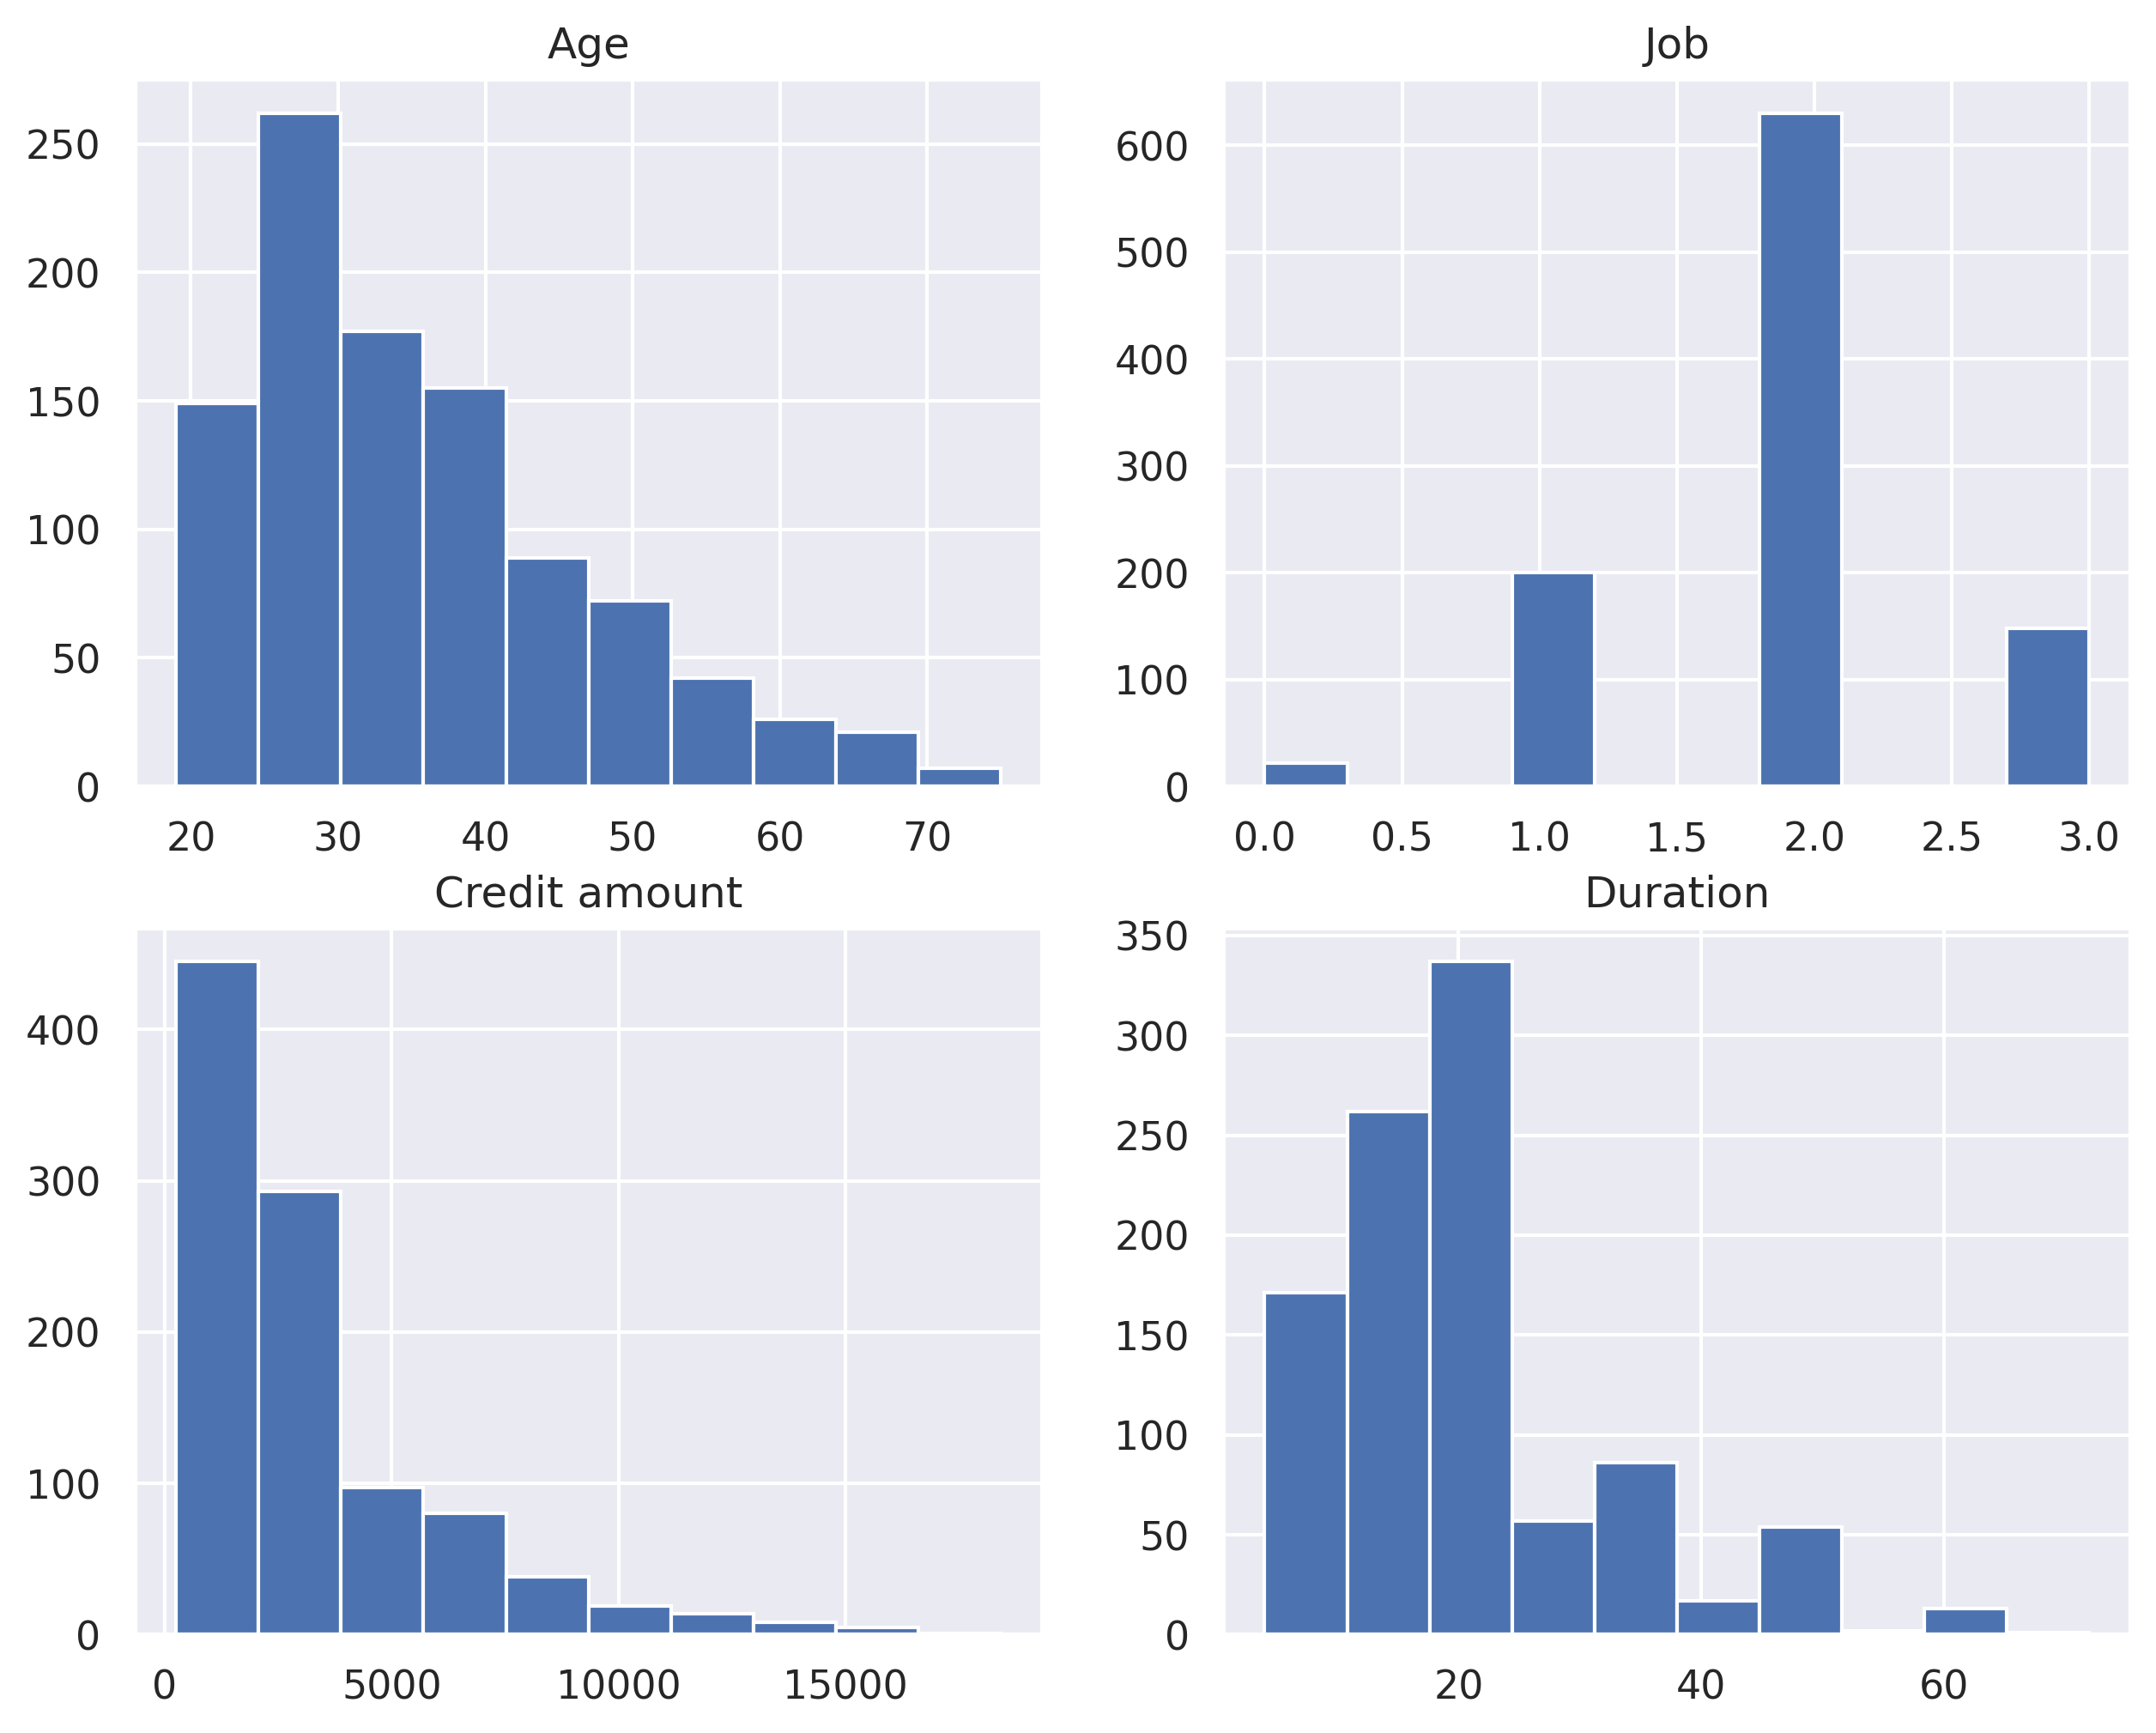

In [10]:
plt.figure(figsize=(10, 8))
k = 0
cols = numerical_credit.columns
for i, j in zip(range(len(cols)), cols):
    k +=1
    plt.subplot(2, 2, k)
    plt.hist(numerical_credit.iloc[:, i])
    plt.title(j)

In [11]:
from sklearn.preprocessing import StandardScaler
import numpy as np

In [12]:
scaler = StandardScaler()
scaled_credit = scaler.fit_transform(numerical_credit)

df_scaled = pd.DataFrame(scaled_credit)
df_scaled['Risk'] = credit['Risk']
df_scaled.columns = ['Age', 'Job', 'Credit amount', 'Duration', 'Risk']

df_scaled['Risk'].value_counts()

good    700
bad     300
Name: Risk, dtype: int64

In [13]:
from sklearn.model_selection import train_test_split

df_scaled['Risk'] = df_scaled['Risk'].replace({'good': 1, 'bad': 0})

X = df_scaled.drop('Risk', axis=1)
y = df_scaled.loc[:, ['Risk']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = y_train['Risk']
y_test = y_test['Risk']

In [14]:
!pip install imblearn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [15]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve


from imblearn.combine import SMOTEENN
smote = SMOTEENN(random_state = 2)

X_train, y_train = smote.fit_resample(X_train, y_train.ravel())

In [16]:
len(y_train)
np.count_nonzero(y_train == 1)

199

## Logistic Regression for PD Estimation

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
import warnings
warnings.filterwarnings('ignore')

In [ ]:
logit = sm.Logit(y_train, X_train)
logit_fit = logit.fit()
print(logit_fit.summary())

Optimization terminated successfully.
         Current function value: 0.513461
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                  456
Model:                          Logit   Df Residuals:                      452
Method:                           MLE   Df Model:                            3
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                  0.2505
Time:                        10:38:40   Log-Likelihood:                -234.14
converged:                       True   LL-Null:                       -312.38
Covariance Type:            nonrobust   LLR p-value:                 1.055e-33
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Age               0.7812      0.124      6.285      0.000       0.538       1.025
Job               0.

In [ ]:
pred_prob = logit_fit.predict(X_test)

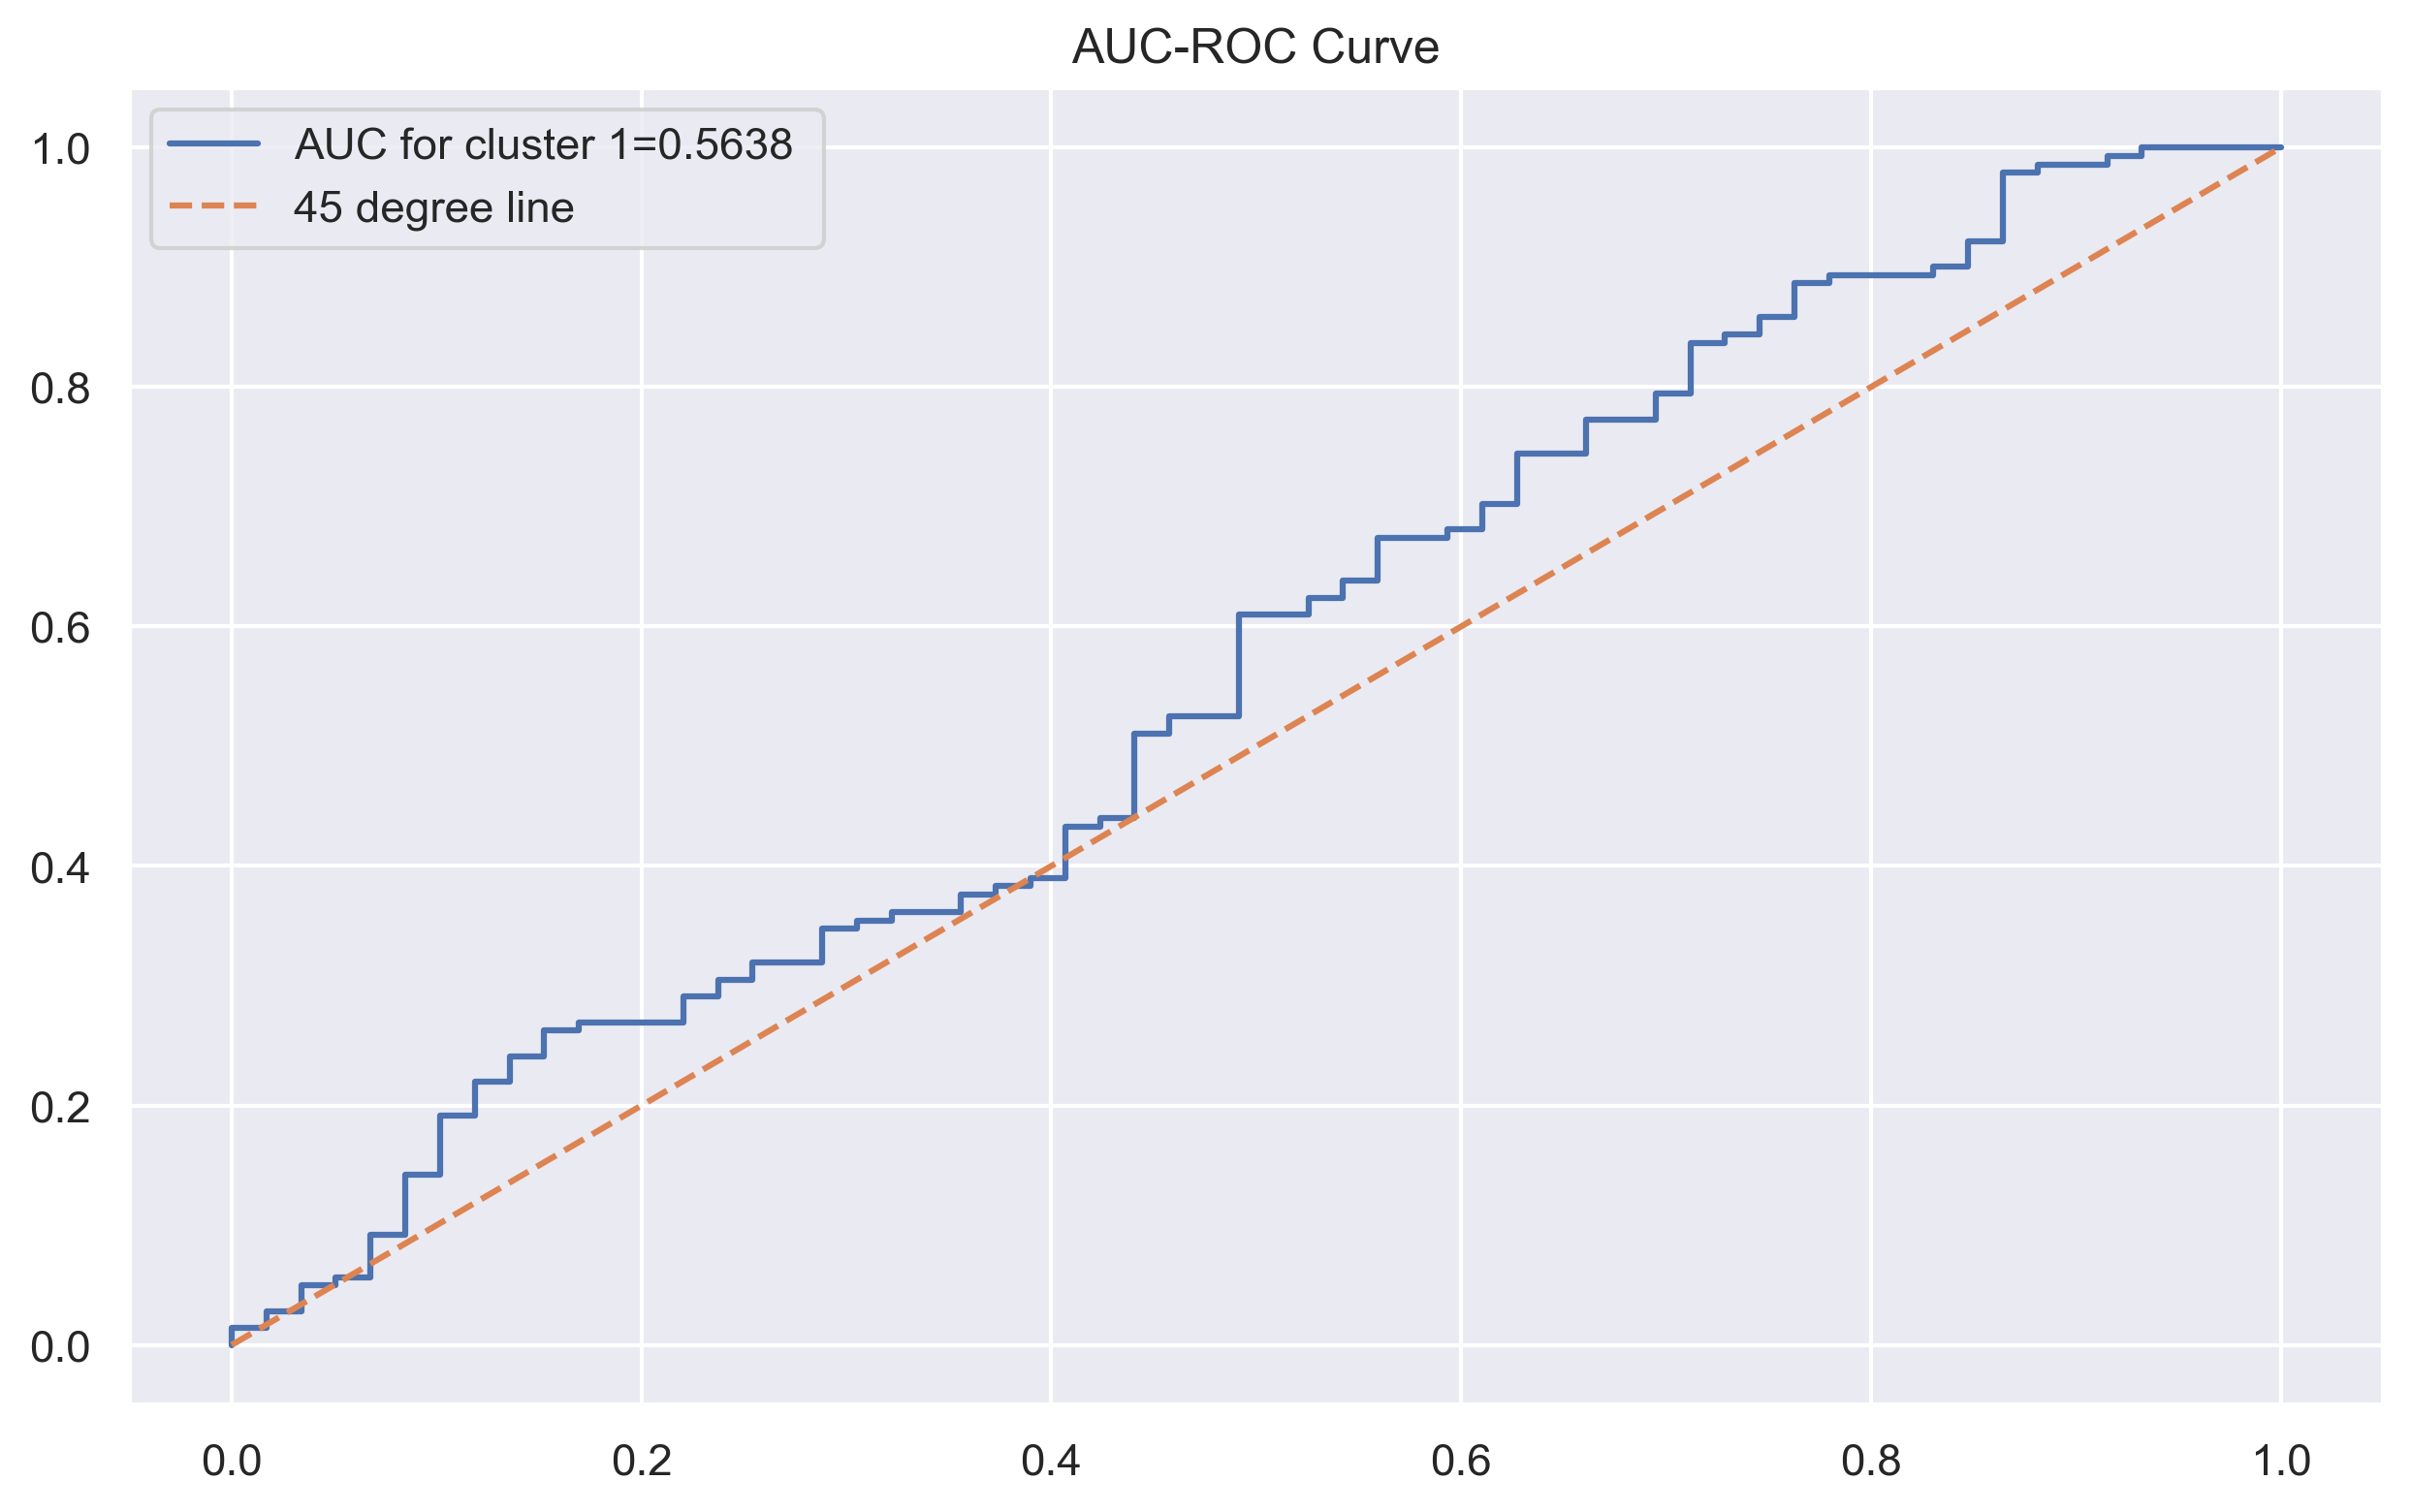

In [ ]:
false_pos, true_pos, _ = roc_curve(y_test.values,  pred_prob)
auc = roc_auc_score(y_test, pred_prob)
plt.plot(false_pos,true_pos, label="AUC for cluster 1={:.4f} "
         .format(auc))
plt.plot([0, 1], [0, 1], linestyle = '--', label='45 degree line')
plt.legend(loc='best')
plt.title('AUC-ROC Curve')
plt.show()

## Bayesian Approach for PD Estimation

In [ ]:
!pip install pymc3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 872 kB 30.1 MB/s 
     |████████████████████████████████| 1.8 MB 59.0 MB/s 
  Created wheel for theano-pymc: filename=Theano_PyMC-1.1.2-py3-none-any.whl size=1529963 sha256=05248bdfb0c10b966bf8ec143ceb63e1369985077f54cbaea3c7f5de9188e813
  Stored in directory: /root/.cache/pip/wheels/f3/af/8c/5dd7553522d74c52a7813806fc7ee1a9caa20a3f7c8fd850d5
Successfully built theano-pymc


In [ ]:
import pymc3 as pm
import arviz as az

with pm.Model() as logistic_model:
    beta_age = pm.Normal('coeff_age', mu=0, sd=10)
    beta_job = pm.Normal('coeff_job', mu=0, sd=10)
    beta_credit = pm.Normal('coeff_credit_amount', mu=0, sd=10)
    beta_dur = pm.Normal('coeff_duration', mu=0, sd=10)
    p = pm.Deterministic('p', pm.math.sigmoid(beta_age * 
                              X_train['Age'] + beta_job *
                              X_train['Job'] + beta_credit *
                              X_train['Credit amount'] + beta_dur *
                              X_train['Duration']))
with logistic_model:
    observed = pm.Bernoulli("risk", p, observed=y_train)
    map_estimate = pm.find_MAP()

In [ ]:
param_list = ['coeff_age', 'coeff_job',
              'coeff_credit_amount', 'coeff_duration']
params = {}
for i in param_list:
    params[i] = [np.round(map_estimate[i], 6)] 
    
bayesian_params = pd.DataFrame.from_dict(params)    
print('The result of Bayesian estimation:\n {}'.format(bayesian_params))

The result of Bayesian estimation:
    coeff_age  coeff_job  coeff_credit_amount  coeff_duration
0   0.781083   0.197849            -0.456893       -0.843769


## MCMC method

- 10,000 posterior samples to simulate the posterior distribution for two independent Markov chain

In [ ]:
import logging
logger = logging.getLogger('pymc3')
logger.setLevel(logging.ERROR)

ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.
ERROR:arviz.data.io_pymc3_3x:Got error No model on context stack. trying to find log_likelihood in translation.


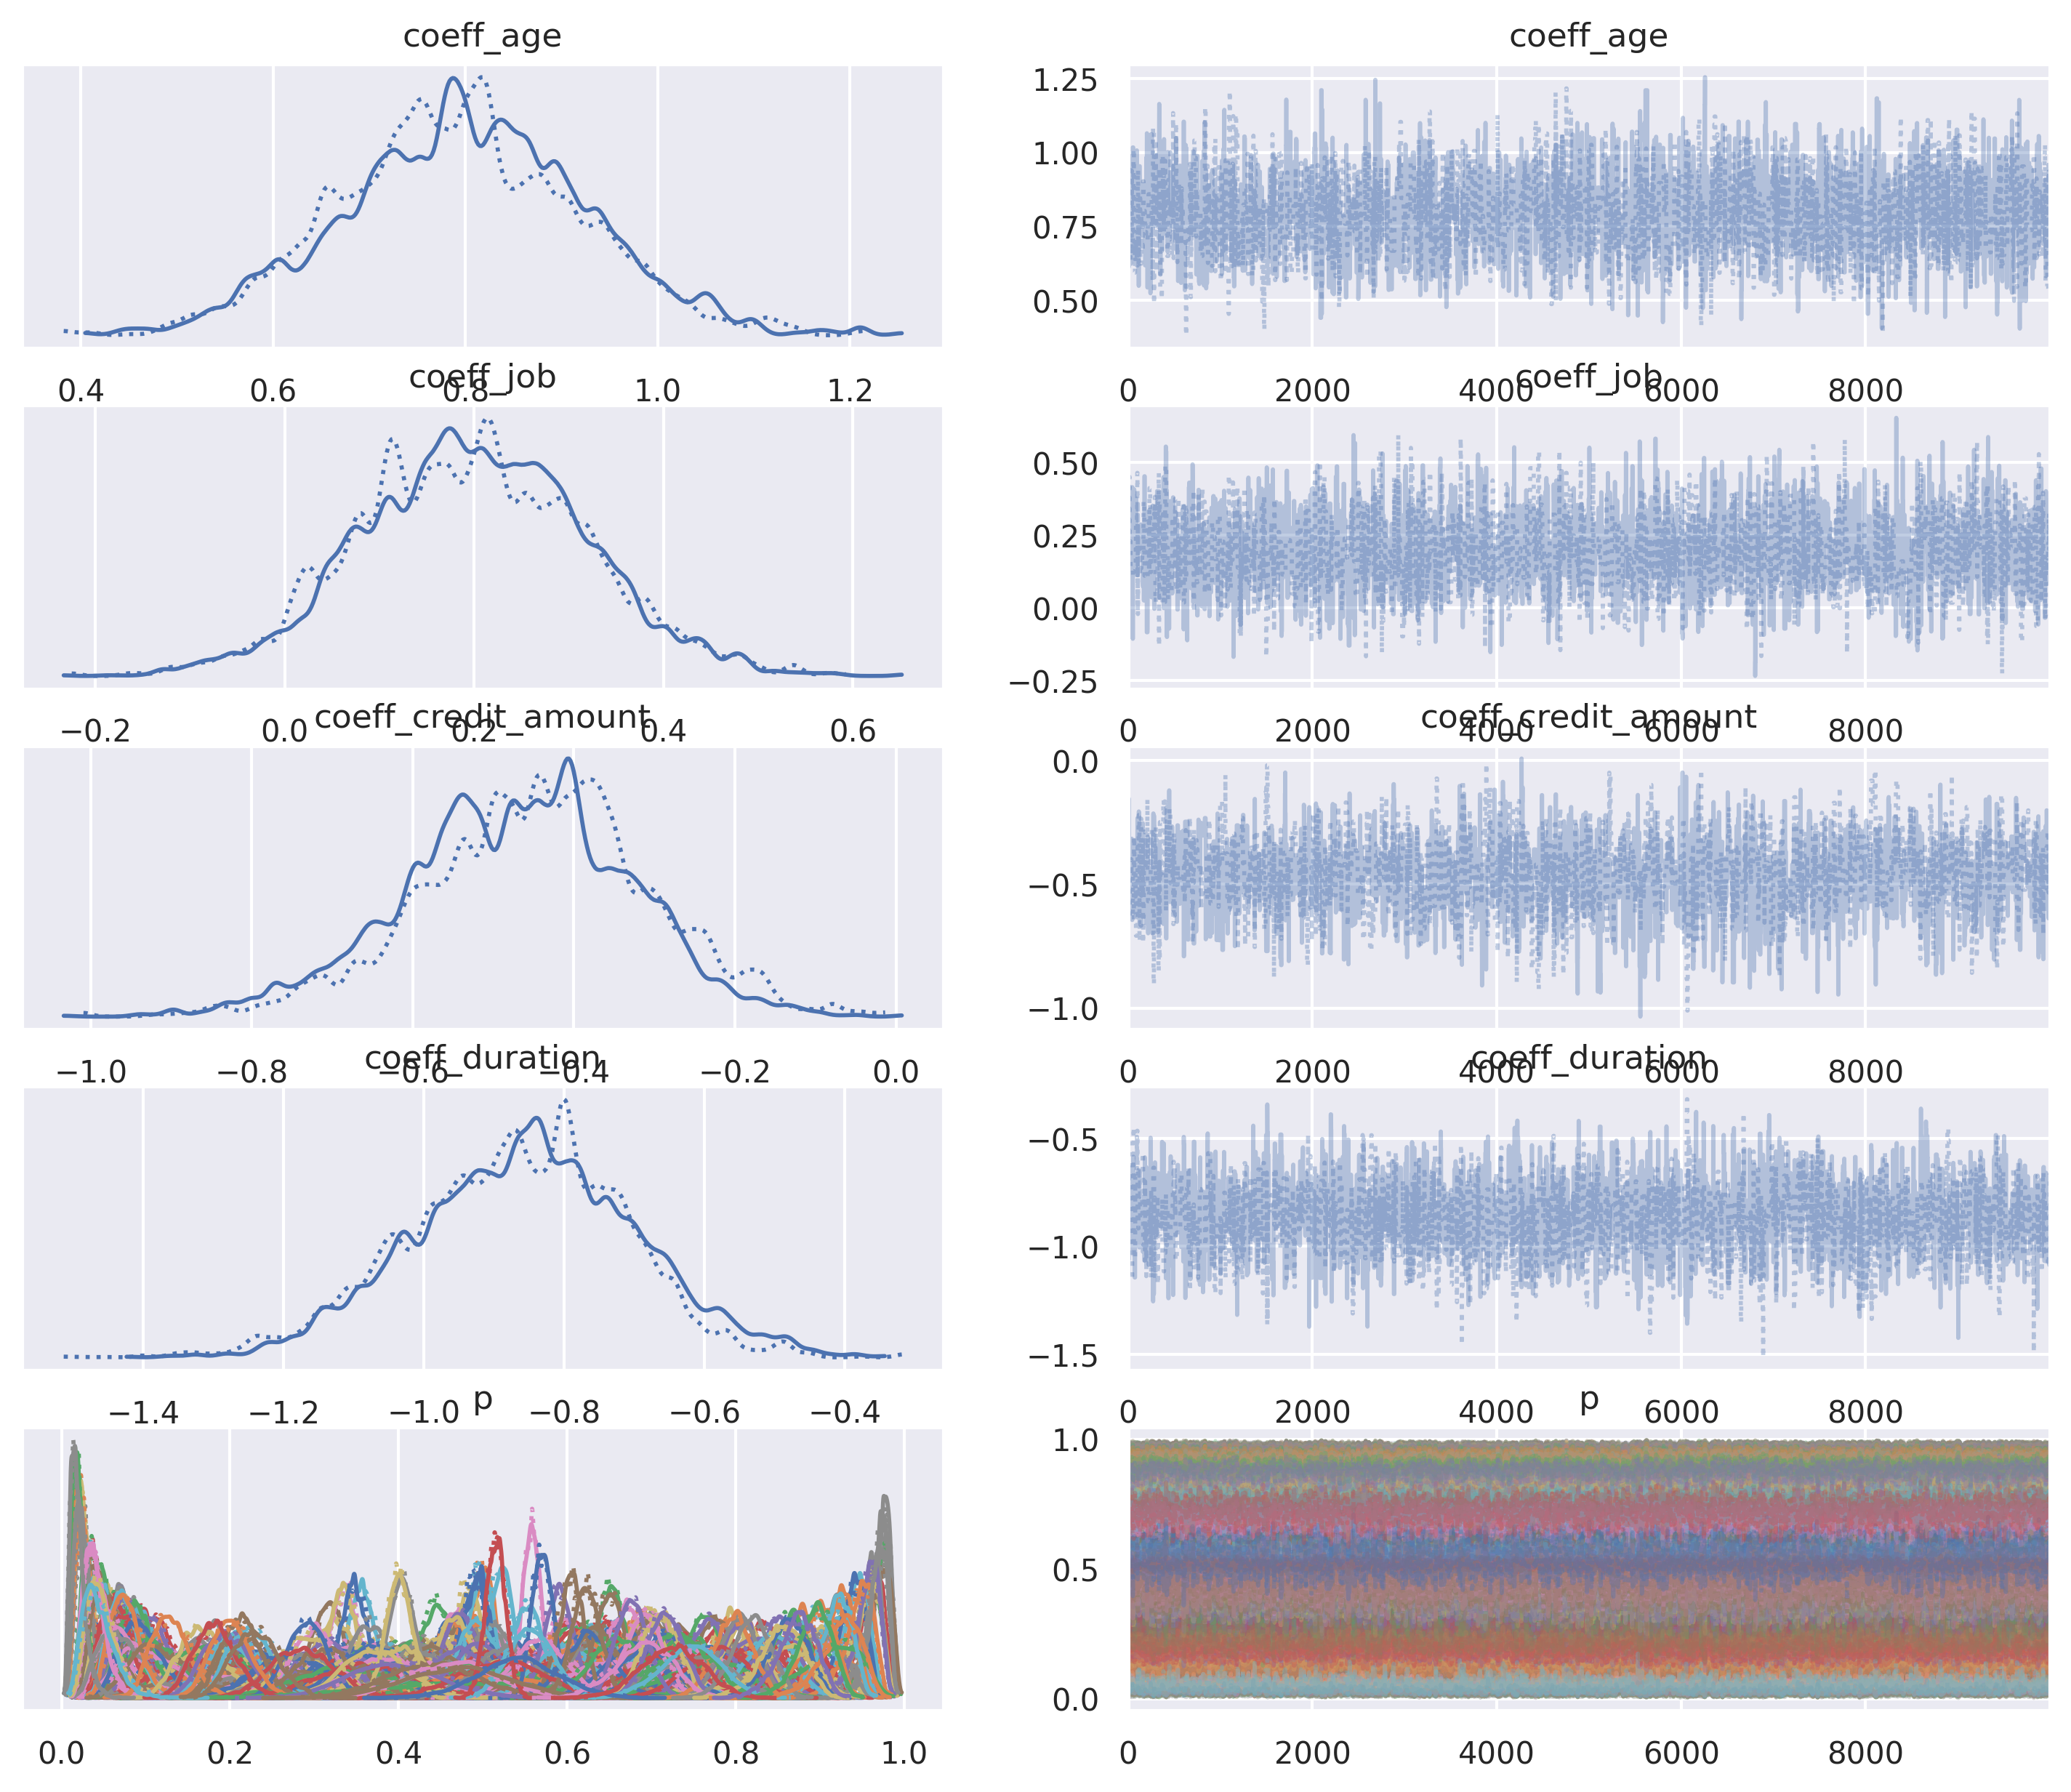

In [ ]:
with logistic_model:
    step = pm.Metropolis()
    trace = pm.sample(10000, step=step,progressbar = False)
az.plot_trace(trace)
plt.show()

In [ ]:
with logistic_model:
    display(az.summary(trace, round_to=6)[:4])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
coeff_age,0.796444,0.125166,0.563994,1.029211,0.002976,0.002110,1773.605187,2413.001132,1.002808
coeff_job,0.198499,0.119082,-0.029083,0.415499,0.002861,0.002029,1739.139453,2046.894543,1.001329
coeff_credit_amount,-0.459454,0.141246,-0.739322,-0.201121,0.004406,0.003117,1023.610224,1660.272442,1.008177
coeff_duration,-0.863804,0.154714,-1.162450,-0.584764,0.003701,0.002617,1747.714401,2038.342584,1.002930


## SVM for PD Estimation

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.svm import SVC
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV
import time

In [ ]:
param_svc = {'gamma': [1e-6, 1e-2],
             'C':[0.001,.09,1,5,10],
             'kernel':('linear','rbf')}

In [ ]:
svc = SVC(class_weight='balanced')
halve_SVC = HalvingRandomSearchCV(svc, param_svc, 
                                  scoring = 'roc_auc', n_jobs=-1)
halve_SVC.fit(X_train, y_train)
print('Best hyperparameters in SVC {} with {}'.
      format(halve_SVC.best_score_, halve_SVC.best_params_))

Best hyperparameters in SVC 0.819048159614723 with {'kernel': 'rbf', 'gamma': 0.01, 'C': 10}


In [ ]:
y_pred_SVC = halve_SVC.predict(X_test)

print('The ROC AUC score of SVC for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_SVC)))

The ROC AUC score of SVC for first cluster is 0.5586


In [ ]:
# Polynomical kernel
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

poly_svm = SVC(kernel="poly", degree=3, coef0=1, C=5)


poly_svm.fit(X_train, y_train)

y_pred_svm_poly = poly_svm.predict(X_test)

print('The ROC AUC score of SVC_poly for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_svm_poly)))

The ROC AUC score of SVC_poly for first cluster is 0.5641


In [ ]:
# Gaussian RBF Kernel

rbf_svm = SVC(kernel="rbf", degree=3, coef0=1, C=5)


rbf_svm.fit(X_train, y_train)

y_pred_svm_rbf = rbf_svm.predict(X_test)

print('The ROC AUC score of SVC_poly for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_svm_rbf)))

The ROC AUC score of SVC_poly for first cluster is 0.5896


## Decision Tree for PD Estimation

In [ ]:
from sklearn.tree import DecisionTreeClassifier

tree_clf=DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

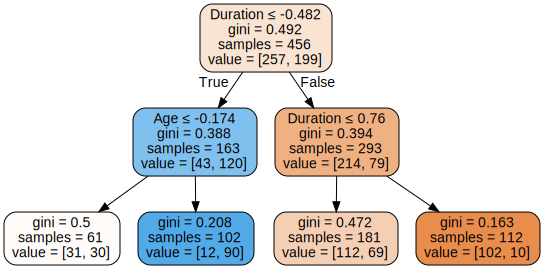

In [ ]:
%matplotlib inline

import os, sys
from pathlib import Path
from sklearn.tree import export_graphviz
import graphviz


sys.path.insert(1, os.path.join(sys.path[0], '..'))

results_path = Path('results', 'decision_trees')
if not results_path.exists():
    results_path.mkdir(parents=True)




out_file = results_path / 'credit_tree_1.dot'

export_graphviz(
    tree_clf,
    out_file=out_file.as_posix(),
    feature_names=X_train.columns,
#    class_names=credit
    rounded=True,
    filled=True,
    special_characters=True)

if out_file is not None:
    dot_data = Path(out_file).read_text()

graphviz.Source(dot_data)

In [ ]:
y_pred_dt = tree_clf.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_dt)))

The ROC AUC score of RF for first cluster is 0.5599


## Random Forest for PD Estimation

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=42)
param_rfc = {'n_estimators': [100, 300],
    'criterion' :['gini', 'entropy'],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [3, 4, 5, 6],
    'min_samples_split':[5, 10]}

In [ ]:
halve_RF = HalvingRandomSearchCV(rfc, param_rfc,
                                 scoring = 'roc_auc', n_jobs=-1)
halve_RF.fit(X_train, y_train)
print('Best hyperparameters in RF {} with {}'.
      format(halve_RF.best_score_, halve_RF.best_params_))

Best hyperparameters in RF 0.9414065918765168 with {'n_estimators': 100, 'min_samples_split': 5, 'max_features': 'auto', 'max_depth': 5, 'criterion': 'entropy'}


In [ ]:
y_pred_RF = halve_RF.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_RF)))

The ROC AUC score of RF for first cluster is 0.5718


#### Bagging

In [ ]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)
bag_clf.fit(X_train, y_train)
y_pred_rf_bagging = bag_clf.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_rf_bagging)))

The ROC AUC score of RF for first cluster is 0.5917


In [ ]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test, y_pred_rf_bagging))

0.605


#### Boosting

- AdaBoosting

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

In [ ]:
y_pred_rf_ada = ada_clf.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_rf_ada)))

The ROC AUC score of RF for first cluster is 0.5996


- Gradient Boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

In [ ]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

In [ ]:
y_pred_rf_gbrt = gbrt.predict(X_test)
print('The ROC AUC score of RF for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_rf_gbrt)))

The ROC AUC score of RF for first cluster is 0.6983


## Neural Networks

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV

from sklearn.neural_network import MLPClassifier

In [18]:
param_NN = {"hidden_layer_sizes": [(100, 50), (50, 50), (10, 100)],
            "solver": ["lbfgs", "sgd", "adam"], 
            "learning_rate_init": [0.001, 0.05]}

In [19]:
MLP = MLPClassifier(random_state=42)

In [20]:
param_halve_NN = HalvingRandomSearchCV(MLP, param_NN,
                                       scoring = 'roc_auc')
param_halve_NN.fit(X_train, y_train)
print('Best hyperparameters for first cluster in NN are {}'.
      format(param_halve_NN.best_params_))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 18 is smaller than n_iter=22. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:774: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 221, in __call__
    sample_weight=sample_weight,
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_scorer.py", line 381, in _score
    return self._sign * self._score_func(y, y_pred, **self._kwargs)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py", lin

Best hyperparameters for first cluster in NN are {'solver': 'sgd', 'learning_rate_init': 0.05, 'hidden_layer_sizes': (10, 100)}


/usr/local/lib/python3.7/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:696: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  ConvergenceWarning,


In [21]:
y_pred_NN = param_halve_NN.predict(X_test)
print('The ROC AUC score of NN for first cluster is {:.4f}'.
      format(roc_auc_score(y_test, y_pred_NN)))

The ROC AUC score of NN for first cluster is 0.5933


## Deep Learning 

In [ ]:
#!pip install tensorflow

In [22]:
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)

In [23]:
def DL_risk(dropout_rate,verbose=0):
    model = keras.Sequential()
    model.add(Dense(128,kernel_initializer='normal', activation = 'relu', input_dim=4))
    model.add(Dense(64, kernel_initializer='normal', activation = 'relu'))
    model.add(Dense(8,kernel_initializer='normal', activation = 'relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation="sigmoid"))
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model

In [24]:
parameters = {'batch_size':  [10, 50, 100],
          'epochs':  [50, 100, 150],
             'dropout_rate':[0.2, 0.4]}
model = KerasClassifier(build_fn = DL_risk)
gs = GridSearchCV(estimator = model,
                       param_grid = parameters,
                          scoring = 'roc_auc')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  after removing the cwd from sys.path.


In [ ]:
gs.fit(X_train, y_train, verbose=0)
print('Best hyperparameters for first cluster in DL are {}'.
      format(gs.best_params_))

In [ ]:
model = KerasClassifier(build_fn = DL_risk,
                        dropout_rate = gs.best_params_['dropout_rate'],
                        verbose = 0,
                        batch_size = gs.best_params_['batch_size'],
                        epochs = gs.best_params_['epochs'])
model.fit(X_train, y_train)
DL_predict = model.predict(X_test)
DL_ROC_AUC = roc_auc_score(y_test, pd.DataFrame(DL_predict.flatten()))
print('DL_ROC_AUC is {:.4f}'.format(DL_ROC_AUC))

7/7 [==============================] - 0s 1ms/step
DL_ROC_AUC is 0.5943


### Different models of DNN

In [35]:
# We can make model using tensorflow Keras

epochs=50
batch_size=50
validation_split=0.2
dropout_rate=0.3
classes=1

model_DNN=tf.keras.models.Sequential()
model_DNN.add(keras.layers.Dense(128, activation='relu', input_dim=4))
model_DNN.add(keras.layers.Dense(64, kernel_initializer='normal', activation='relu'))
model_DNN.add(keras.layers.Dense(8, kernel_initializer='normal', activation='relu'))
model_DNN.add(keras.layers.Dropout(dropout_rate))
model_DNN.add(keras.layers.Dense(classes, activation="sigmoid"))

model_DNN.summary()



Model: "sequential_95"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_373 (Dense)           (None, 128)               640       
                                                                 
 dense_374 (Dense)           (None, 64)                8256      
                                                                 
 dense_375 (Dense)           (None, 8)                 520       
                                                                 
 dropout_93 (Dropout)        (None, 8)                 0         
                                                                 
 dense_376 (Dense)           (None, 1)                 9         
                                                                 
Total params: 9,425
Trainable params: 9,425
Non-trainable params: 0
_________________________________________________________________


In [41]:
# compiling the model
model_DNN.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# training the model
model_DNN.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=validation_split, verbose=0)

In [42]:
# evalution the model
test_loss, test_acc=model_DNN.evaluate(X_test, y_test)
print('Test accuracy', test_acc)

DNN_predict = model_DNN.predict(X_test)
DNN_ROC_AUC = roc_auc_score(y_test, pd.DataFrame(DNN_predict.flatten()))
print('DNN_ROC_AUC is {:.4f}'.format(DNN_ROC_AUC))


7/7 [==============================] - 0s 3ms/step - loss: 1.2756 - accuracy: 0.5400
Test accuracy 0.5400000214576721
7/7 [==============================] - 0s 2ms/step
DNN_ROC_AUC is 0.6241
